# Pneumonia Detection Using Convolutional Neural Network

In [26]:
import tensorflow as tf

print("Available devices:")
print(tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available; using CPU instead.")


Available devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is available.


In [27]:
tf.debugging.set_log_device_placement(True)

## Exploratory Data Analysis

### Data Download & Extraction

In [28]:
import os
import zipfile

Please uncomment below cells to download and extract the dataset.

### Dataset Structure

The dataset is divided into 2 directories:
- train
- test

Within each directory, there're 2 sub-directories:
- NORMAL
- PNEUMONIA

and the labels for the images are the names of the corresponding directories they're located in.

```
chest_xray
    │
    ├── test
    │   ├── NORMAL
    │   │   └── image_01.jpeg
    │   └── PNEUMONIA
    │       └── image_02.jpeg
    └── train
        ├── NORMAL
        │   └── image_01.jpeg
        └── PNEUMONIA
            └── image_02.jpeg

```

### Data Preview

First, I will load and view a few images in each group just to have some general ideas of what type of images we will be working with.

In [29]:
# conda install -c conda-forge opencv


In [30]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


#### NORMAL

In [31]:
import numpy as np
import pandas as pd
from keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from PIL import Image
import cv2
import seaborn as sns

In [32]:
import warnings
warnings.filterwarnings('ignore')

#### Image Size

In [33]:
Image.open('/home/agaonkar/private/chest_xray/train/NORMAL/IM-0115-0001.jpeg').size

(2090, 1858)

In [34]:
Image.open('/home/agaonkar/private/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg').size

(712, 439)

It seems like the images are relatively large, with each dimension being roughly 700-1800 pixels. They don't have uniform size, therefore, we'll need to rescale them later.

#### Image Shape/Number of Channels

In [35]:
img = cv2.imread('/home/agaonkar/private/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg')
print(img.shape)

(439, 712, 3)


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

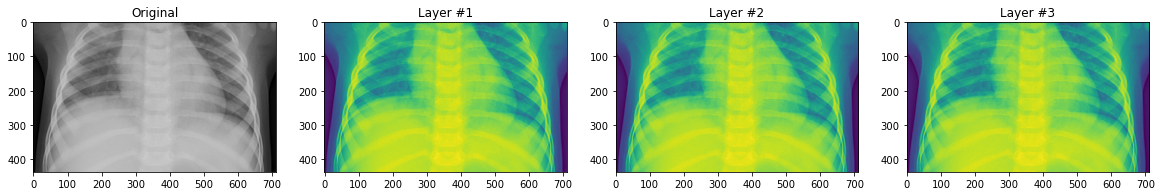

In [37]:
# DISPLAYING ORIGINAL & EACH LAYER SEPARATELY
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
axes[0].imshow(img)
axes[0].set_title('Original')

for i in range(1,4):
    ax = axes[i]
    ax.imshow(img[:, :, (i-1)])
    ax.set_title(f'Layer #{i}')

plt.savefig('/home/agaonkar/private/img_breakdown.png', bbox_inches='tight', dpi=300);

At first look, these 3 layers appear to be identical, but we can also reconfirm by comparing the pixel values of the 3 layers:

In [38]:
print((img[:, :, 0] == img[:, :, 1]).all())
print((img[:, :, 0] == img[:, :, 2]).all())

True
True


I am not entirely sure why these grayscale X-ray images have 3 channels or RGB, and the numeric values for all 3 layers are exactly the same. For this reason, moving forward, I would set `ImageDataGenerator()`'s `color_mode` to `grayscale` to downsize the dataset, while still retaining the same amount of information.

### DataFrames

#### Class Composition
In order to look at the class composition and evaluate its balancedness, I would create a dataframe with 2 columns:

- **1st column**: name of the image file - called `image`
- **2nd column**: label for that image - called `label`

In [39]:
import glob
from pathlib import Path

In [40]:
# GET THE DIRECTORY TO THE DATASETS
path_data = '/home/agaonkar/private/chest_xray'
path_train = os.path.join(path_data, 'train')
path_test = os.path.join(path_data, 'test')

# INITIATE EMPTY LIST OF TRAINING DATA
# THAT WILL BE CONVERTED TO PANDAS DATAFRAME LATER
data_train = []
data_test = []
data = [data_train, data_test]

# ITERATE THROUGH EACH PATH
for i, d in enumerate([path_train, path_test]):
    # GET THE PATH TO EACH FOLDER - NORMAL AND PNEUMONIA
    normal = os.path.join(d, 'NORMAL')
    pneumonia = os.path.join(d, 'PNEUMONIA')

    # FETCH ALL .jpeg FILES
    normal_imgs = Path(normal).glob('*.jpeg')
    pneumonia_imgs = Path(pneumonia).glob('*.jpeg')

    # APPEND THE NAME AND CORRESPONDING LABEL (BASED ON FOLDER NAME)
    # TO data_train list AS TUPLES
    for img in normal_imgs:
        data[i].append((str(img), 0))

    for img in pneumonia_imgs:
        data[i].append((str(img), 1))

In [41]:
# CONVERT data_train TO DATAFRAME FOR EASY MANIPULATION
columns = ['image', 'label']

train_df = pd.DataFrame(data_train, columns=columns)
test_df = pd.DataFrame(data_test, columns=columns)

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5216 non-null   object
 1   label   5216 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.6+ KB


In [43]:
train_df.label.value_counts(normalize=True)

label
1    0.742906
0    0.257094
Name: proportion, dtype: float64

In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   624 non-null    object
 1   label   624 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.9+ KB


In [45]:
test_df.label.value_counts(normalize=True)

label
1    0.625
0    0.375
Name: proportion, dtype: float64

There are 5232 images in the training set (with an approximately 3:1 class ratio), and only 16 in validation (with a 1:1 ratio).

Due to a potential "mislabeling" issue in the test data (which has been raised about this dataset in various different platforms), I'm going to concatenate both sets together and re-split them into Train/Validation/Test later to ensure data consistency.

In [46]:
# CONCAT train_df and val_df
master_df = pd.concat([train_df, test_df])
# RESET INDEX (SO THERE WON'T BE ANY DUPLICATED INDICES) BY DROPPING OLD ONES
master_df.reset_index(inplace=True, drop=True)

In [47]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5840 non-null   object
 1   label   5840 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.4+ KB


In [48]:
# CHECK FOR DUPLICATES
master_df.duplicated().any()

False

In [49]:
# FETCH 10 RANDOM SAMPLES FROM master_df
master_df.sample(10, random_state=42)

,image,label
4582,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
177,/home/agaonkar/private/chest_xray/train/NORMAL...,0
167,/home/agaonkar/private/chest_xray/train/NORMAL...,0
3722,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
2339,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
1047,/home/agaonkar/private/chest_xray/train/NORMAL...,0
4676,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
3955,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
2534,/home/agaonkar/private/chest_xray/train/PNEUMO...,1
1501,/home/agaonkar/private/chest_xray/train/PNEUMO...,1


In [50]:
4265 + 1575

5840

In [51]:
master_df.label.value_counts()

label
1    4265
0    1575
Name: count, dtype: int64

In [52]:
master_df.label.value_counts(normalize=True)

label
1    0.730308
0    0.269692
Name: proportion, dtype: float64

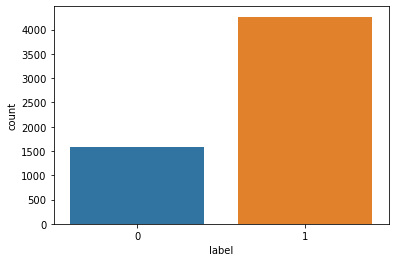

In [53]:
sns.countplot(x='label', data=master_df)
plt.savefig('/home/agaonkar/private/class_ratio.png', bbox_inches='tight', dpi=300);

#### Pneumonia Types

Within the Pneumonia class itself, there are two different types: Bacteria and Virus. These 2 subclasses have their own identifable characteristics:
- **Bacterial pneumonia** typically exhibits a focal lobar consolidation
- whereas **Viral pneumonia** manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs

These differences would potentially impact the models' capabilities to differentiate the X-ray images; therefore it might be valuable to include this information in the model evaluation. This would not be the main focus of this project, but it would certainly provide some information for us to dig deeper into this topic in the future, and perhaps train models to classify different types of Pneumonia.

In [54]:
def cat_pneumonia_type(x):
    if 'BACTERIA' in x:
        output = 'bacteria'
    elif 'VIRUS' in x:
        output = 'virus'
    else:
        output = 'normal'
    return output

In [55]:
master_df['type'] = master_df.image.apply(lambda x: cat_pneumonia_type(x))

In [56]:
master_df.type.value_counts()

type
normal    5840
Name: count, dtype: int64

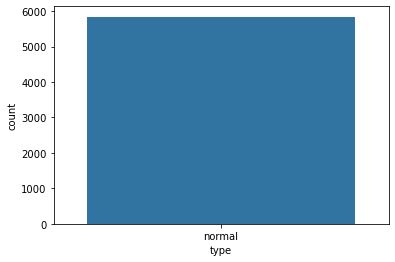

In [57]:
sns.countplot(x='type', data=master_df)
plt.savefig('/home/agaonkar/private/composition.png', bbox_inches='tight', dpi=300);

4273 datapoints in our master dataset are categorized as PNEUMONIA, which accounts for roughly 73% of the whole set:

- Roughly 2/3 of the Pneumonia X-ray images are Bacterial Pneumonia
- The other 1/3 are Viral

This means that we're working with a highly imbalanced dataset, and I would need to counter this by assigning class weights or incorporating some image augmentation methods later. Our models are also going to be less exposed to Viral Pneumonia, and might struggle with these X-ray more than with Bacterial.

### Dataset Splitting

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
# TRAIN TEST SPLIT (TEST SIZE = 15%)
master_train_df, test_df = train_test_split(master_df, test_size=0.15, random_state=42)

In [60]:
# TRAIN VALIDATION SPLIT (VALIDATION SIZE = 20%)
train_df, val_df = train_test_split(master_train_df, test_size=0.2, random_state=42)

In [61]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3971 entries, 234 to 1512
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   3971 non-null   object
 1   label   3971 non-null   int64 
 2   type    3971 non-null   object
dtypes: int64(1), object(2)
memory usage: 124.1+ KB


In [62]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 993 entries, 5768 to 2661
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   993 non-null    object
 1   label   993 non-null    int64 
 2   type    993 non-null    object
dtypes: int64(1), object(2)
memory usage: 31.0+ KB


In [63]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 876 entries, 4582 to 2850
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   876 non-null    object
 1   label   876 non-null    int64 
 2   type    876 non-null    object
dtypes: int64(1), object(2)
memory usage: 27.4+ KB


### Data Generators

Next, we'll use `ImageDataGenerator` to create batches of data for visualization as well as modeling training later on.

In [64]:
BATCH_SIZE = 32

# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='grayscale',   # only keeping 1 channel of the images
    class_mode='raw',
    target_size=(180,180),   # resizing all images to 180 x 180 pixel
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(180,180),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True
)

Found 3971 validated image filenames.
Found 993 validated image filenames.


In [65]:
# CHECKING THE SHAPE OF 1 BATCH OF THE train_generator
images_train, labels_train = next(train_generator)
print(f'Training set: {images_train.shape} | {labels_train.shape}')

Training set: (32, 180, 180, 1) | (32,)


The shape printout shows that we have 32 images with 32 corresonding labels. Each image is in grayscale (1 channel) and 180 x 180 pixel in size.

### Data Visualization

Next, I am going to display the first 16 images of the first batch with their corresponding labels:

- 0 - NORMAL
- 1 - PNEUMONIA

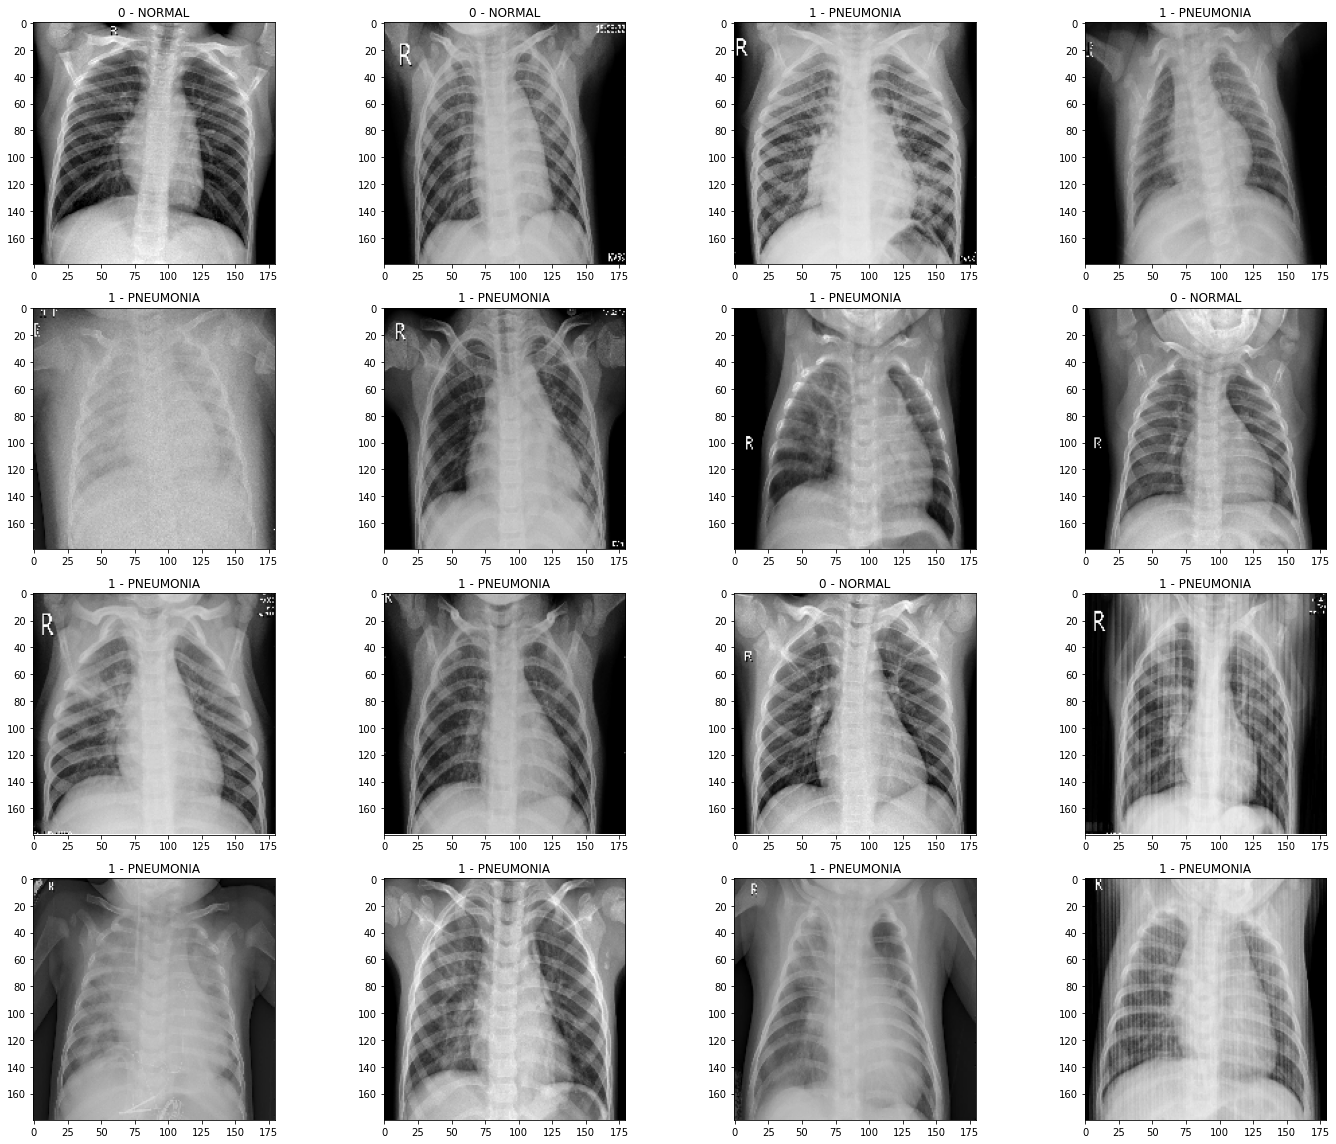

In [66]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,16))
label_output = {0: 'NORMAL', 1: 'PNEUMONIA'}
i = range(16)

for i in range(16):
    ax = axes[i // 4][i % 4]
    ax.imshow(images_train[i], cmap='gray')
    ax.set_title(f'{labels_train[i]} - {label_output[labels_train[i]]}')

plt.tight_layout()
plt.savefig('/home/agaonkar/private/samples_16.png', bbox_inches='tight', dpi=300);
plt.show();

### Correcting Class Imbalances & Data Augmentation

In [67]:
from sklearn.utils import class_weight

#### Class Weights

In [68]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=train_df['label'].unique(),
                                                  y=train_df['label'])

In [69]:
print(train_df['label'].unique())
print(class_weights)

[0 1]
[1.84354689 0.68607464]


In [70]:
class_weight = {0: class_weights[0], 1: class_weights[1]}
class_weight

{0: 1.8435468895078924, 1: 0.6860746371803732}

#### Image Data Augmentation

Our dataset has close to 6000 images, with some class imbalance. In this case, models' robustness could perhaps be improved with the use of additional synthesized images from the original dataset. Exposing the models to more variants of the data could potentially increase our model's ability to generalize to unseen images.

In [71]:
# CREATE AN AUGMENTATION GENERATOR FOR TRAINING DATASET
aug = ImageDataGenerator(rescale=1.0/255,
                         horizontal_flip=True,
                         rotation_range=10)

- **Horizontal flip** is going to flip the whole image to the right, which might help our model detect cases in which the patiences have this condition. However, it's not too common, so it might end up hurting the model's learning.
- Some of the images in the dataset seem to be slightly rotated (2 of the 7 Pneumonia cases that have been consistenly missed by all 5 models are rotated to the left), therefore I think adding some **rotation** to the `ImageDataGenerator` object might help.

In [72]:
# # CREATE NEW GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
aug_train_generator = aug.flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(180,180),
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples

)

Found 3971 validated image filenames.


In [73]:
images_train, labels_train = next(aug_train_generator)

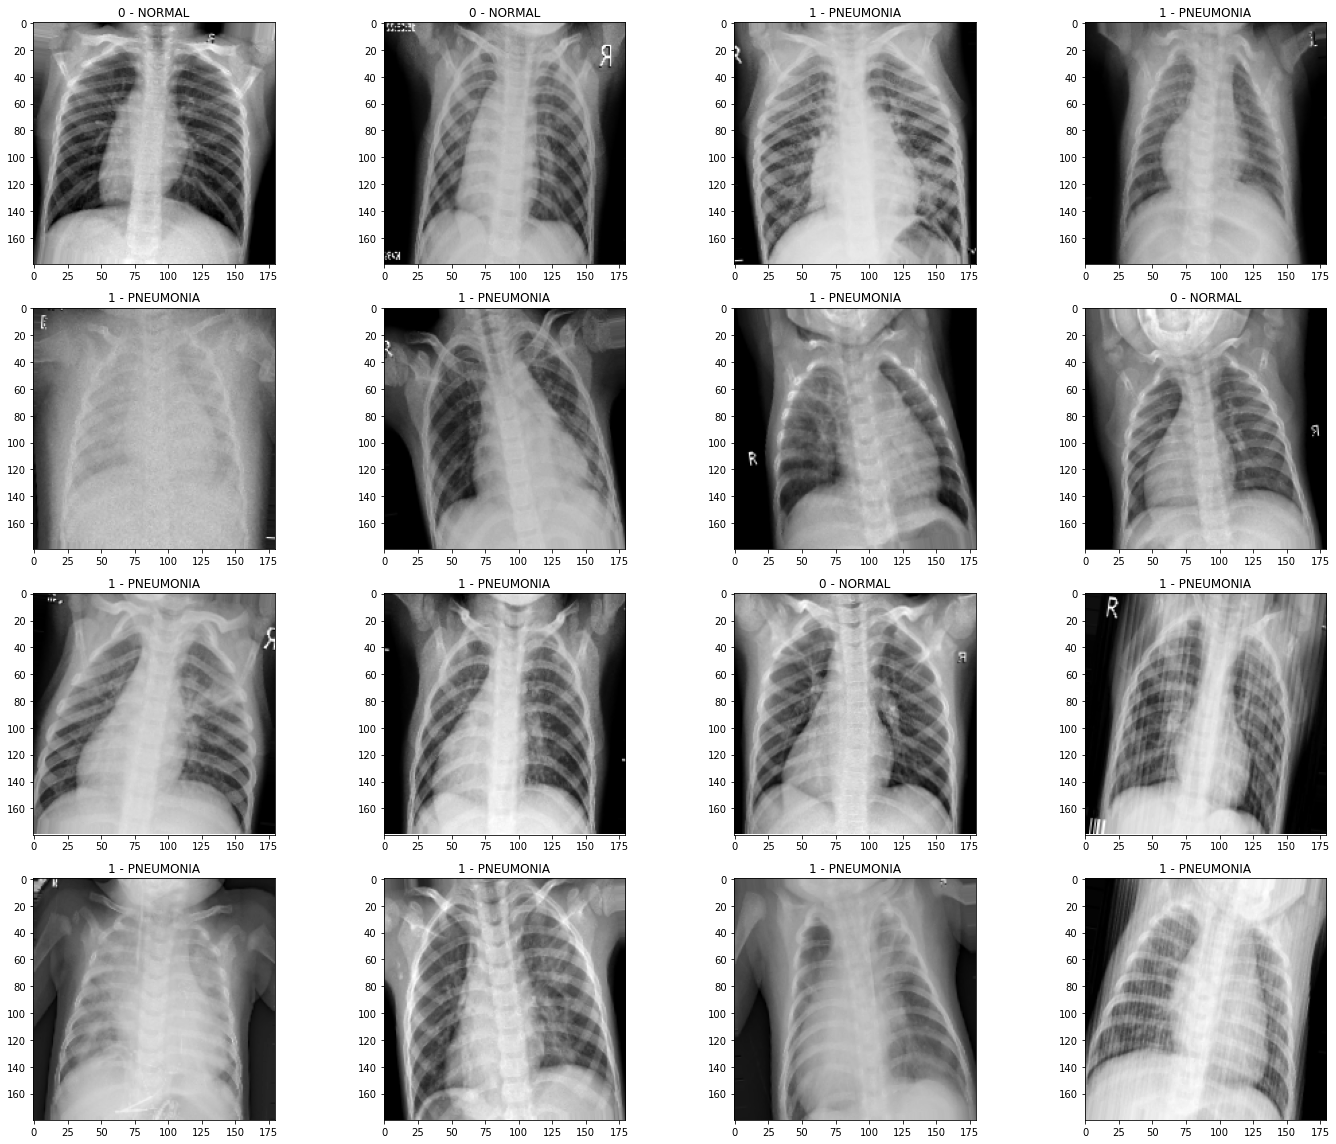

In [74]:
# AUGMENTED DATA VISUALIZAITON
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,16))
label_output = {0: 'NORMAL', 1: 'PNEUMONIA'}
i = range(16)

for i in range(16):
    ax = axes[i // 4][i % 4]
    ax.imshow(images_train[i], cmap='gray')
    ax.set_title(f'{labels_train[i]} - {label_output[labels_train[i]]}')

plt.tight_layout()
plt.show()

In [75]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.metrics import Recall, Precision
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers.schedules import ExponentialDecay

In [76]:
from keras.models import Sequential
# CONSTRUCT MODEL LAYERS
cnn_3 = Sequential()
cnn_3.add(Conv2D(32, (3,3), activation='relu', padding='same',
               input_shape=[180,180,1]))
cnn_3.add(MaxPooling2D(pool_size=(2,2)))
cnn_3.add(Conv2D(32, (3,3), activation='relu', padding='same'))
cnn_3.add(MaxPooling2D(pool_size=(2,2)))
cnn_3.add(Flatten())
cnn_3.add(Dense(128, activation='relu'))
cnn_3.add(Dense(64, activation='relu'))
cnn_3.add(Dense(1, activation='sigmoid'))

In [77]:
recall = Recall()
precision = Precision()

In [78]:
# COMPILE MODEL
cnn_3.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy', recall, precision])

# PRINT OUT MODEL SUMMARY
cnn_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 64800)             0         
                                                                 
 dense (Dense)               (None, 128)               8

In [79]:
import keras
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

TimingCallback = TimingCallback()

In [80]:
# INSTANTIATE ModelCheckpoint AND EarlyStopping OBJECTS
checkpoint_cb = ModelCheckpoint('cnn_3.h5',
                                save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True)

# ASSIGN BATCH SIZE AND EPOCH VALUES
BATCH_SIZE = 32
EPOCHS = 30

# FIT MODEL TO DATA
results_3 = cnn_3.fit(
                      aug_train_generator,
                      validation_data=val_generator,
                      epochs=EPOCHS,
                      class_weight=class_weight,
                      steps_per_epoch=(aug_train_generator.n//BATCH_SIZE),
                      validation_steps=(val_generator.n//BATCH_SIZE),
                      callbacks=[checkpoint_cb, early_stopping_cb,TimingCallback])

print(TimingCallback.logs)
print(sum(TimingCallback.logs))

Epoch 1/30


2024-03-02 21:34:51.303030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-02 21:34:52.033220: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fbf6bfffe80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-02 21:34:52.033259: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-03-02 21:34:52.041051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-02 21:34:52.229655: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


124/124 [==============================] - 53s 393ms/step - loss: 0.3761 - accuracy: 0.8088 - recall: 0.7893 - precision: 0.9387 - val_loss: 0.1796 - val_accuracy: 0.9355 - val_recall: 0.9526 - val_precision: 0.9604
Epoch 2/30
124/124 [==============================] - 44s 357ms/step - loss: 0.2254 - accuracy: 0.9091 - recall: 0.9087 - precision: 0.9645 - val_loss: 0.2294 - val_accuracy: 0.9284 - val_recall: 0.9213 - val_precision: 0.9812
Epoch 3/30
124/124 [==============================] - 43s 350ms/step - loss: 0.2250 - accuracy: 0.9129 - recall: 0.9112 - precision: 0.9675 - val_loss: 0.1913 - val_accuracy: 0.9375 - val_recall: 0.9309 - val_precision: 0.9842
Epoch 4/30
124/124 [==============================] - 43s 347ms/step - loss: 0.1911 - accuracy: 0.9256 - recall: 0.9247 - precision: 0.9718 - val_loss: 0.3758 - val_accuracy: 0.8579 - val_recall: 0.8141 - val_precision: 0.9934
Epoch 5/30
124/124 [==============================] - 43s 349ms/step - loss: 0.1939 - accuracy: 0.9266 

In [84]:
# VISUALIZE MODEL PERFORMANCE
def visualize_training_results(results):
    history = results.history
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show();

In [85]:
results_3.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

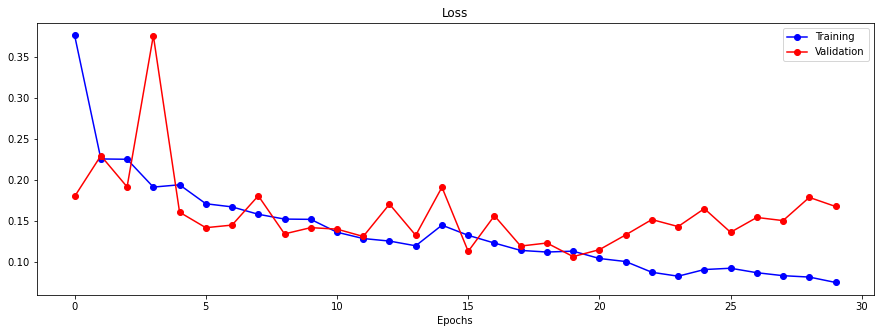

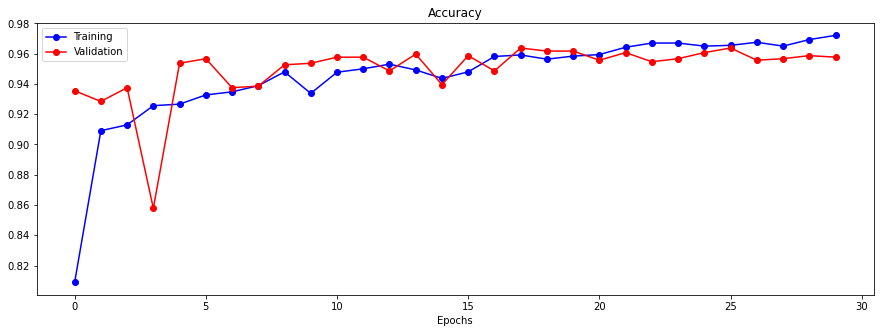

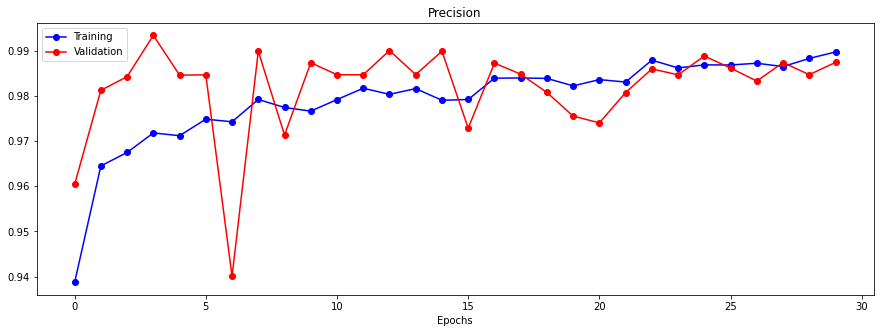

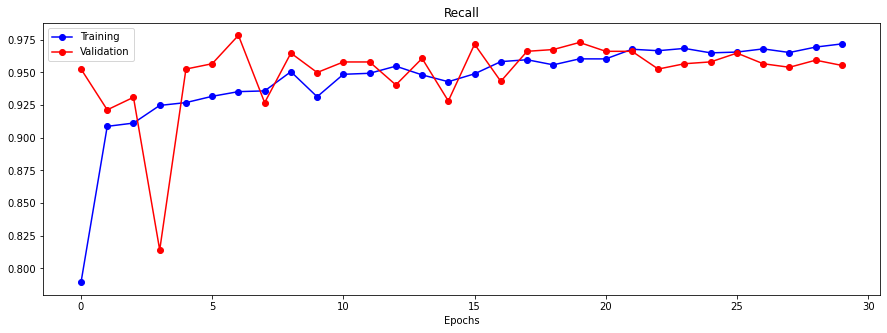

In [86]:
visualize_training_results(results_3)

In [87]:
aug_train_eval_generator = aug.flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    class_mode='raw',
    color_mode='grayscale',
    target_size=(180,180),
    batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=False     # not shuffle so that the predicts come out in the same order as in the original dataset
)

val_eval_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    class_mode='raw',
    color_mode='grayscale',
    target_size=(180,180), batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=False
)

preds_train_3 = cnn_3.predict(aug_train_eval_generator,
                              steps=(aug_train_eval_generator.n//BATCH_SIZE+1),
                              verbose=1,
                              workers=8)
preds_val_3 = cnn_3.predict(val_eval_generator,
                            steps=(val_eval_generator.n//BATCH_SIZE+1),
                            verbose=1,
                            workers=8)



Found 3971 validated image filenames.
Found 993 validated image filenames.
32/32 [==============================] - 1s 27ms/step


In [88]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
def plot_confusionmatrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    ax= plt.subplot()
    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    plt.show();

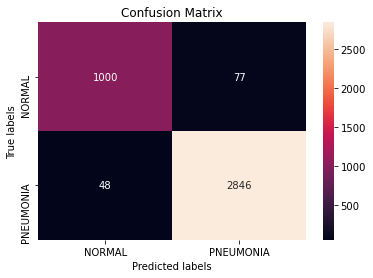

In [89]:
plot_confusionmatrix(train_df['label'], np.rint(preds_train_3))

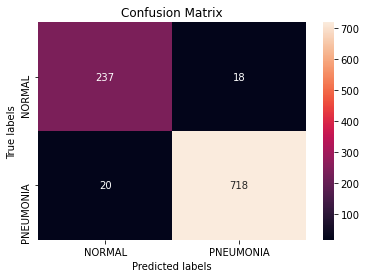

In [90]:
plot_confusionmatrix(val_df['label'], np.rint(preds_val_3))

`cnn_3` has lower loss and higher accuracy values than `cnn_2` does; however it has lower recall score, with a False Negative count of 19. Next, I'll look into the similarities and differences between the False Negative cases of`cnn_2` and `cnn_3`.  

In [92]:
# APPEND PREDICTIONS OF THE cnn_3 MODEL TO val_df FOR COMPARISON WITH
# OTHER MODELS
val_df['cnn_3_pred'] = preds_val_3
val_df.head()

,image,label,type,cnn_3_pred
5768,/home/agaonkar/private/chest_xray/test/PNEUMON...,1,normal,0.893336
2985,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.999732
2671,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.993442
5029,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.913788
2432,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.992479


In [93]:
# PNEUMONIA CASES THAT HAVE BEEN INCORRECTLY PREDICTED BY cnn_6
fn3 = val_df[(val_df.label - np.rint(val_df.cnn_3_pred)) == 1]
fn3

,image,label,type,cnn_3_pred
4543,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.349836
4222,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.159456
4554,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.153600
3179,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.219138
3999,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.348171
3239,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.468280
3164,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.112475
5705,/home/agaonkar/private/chest_xray/test/PNEUMON...,1,normal,0.191841
1790,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.088389
3493,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.200766


In [94]:
# SAVE THE MODEL
cnn_3.save("cnn_3_gpu.h5")

In [104]:
BATCH_SIZE = 32

test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=test_df, x_col='image', y_col='label',
    class_mode='raw',
    color_mode='grayscale',
    target_size=(180,180), batch_size=BATCH_SIZE,
    seed=2021,
    shuffle=False
)

Found 876 validated image filenames.


In [105]:
preds_test_3 = cnn_3.predict(test_generator,
                            steps=(test_generator.n//BATCH_SIZE+1),
                            verbose=1,
                            workers=8)

28/28 [==============================] - 1s 32ms/step


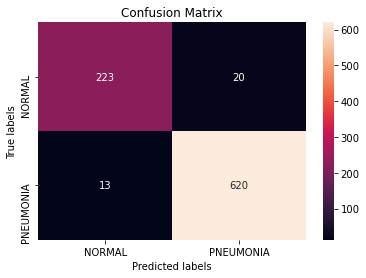

In [106]:
plot_confusionmatrix(test_df['label'], np.rint(preds_test_3)) 

In [108]:
cnn_3.evaluate(test_generator)

28/28 [==============================] - 6s 221ms/step - loss: 0.1091 - accuracy: 0.9623 - recall: 0.9795 - precision: 0.9688


[0.1090971902012825, 0.9623287916183472, 0.9794628620147705, 0.96875]

In [164]:
# CALCULATE cnn_4's PERFORMANCE METRICS ON VALIDATION SET
cnn_3_metrics = cnn_3.evaluate(test_generator)
# CREATE A DATAFRAME TO KEEP TRACK OF ALL MODELS PERFOMANCE ON VALIDATION SET
perf_df = pd.DataFrame(columns=['model', 'loss', 'accuracy', 'recall', 'precision'])
perf_df.loc[len(perf_df.index)] = ['CNN_augmented'] + cnn_3_metrics
perf_df

28/28 [==============================] - 6s 221ms/step - loss: 0.1091 - accuracy: 0.9623 - recall: 0.9795 - precision: 0.9688


,model,loss,accuracy,recall,precision
0,CNN_augmented,0.109097,0.962329,0.979463,0.96875


In [129]:
from sklearn.metrics import confusion_matrix
from math import sqrt

# Compute confusion matrix
cm = confusion_matrix(test_df['label'], np.rint(preds_test_3))
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = TP / (TP + 0.5 * (FP + FN))

# Matthews correlation coefficient (MCC)
mcc_numerator = TN * TP - FN * FP
mcc_denominator = sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
mcc_score = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

# Cohen's Kappa score
kappa_numerator = 2 * (TP * TN - FN * FP)
kappa_denominator = (TP + FP) * (FP + TN) + (TP + FN) * (FN + TN)
kappa_score = kappa_numerator / kappa_denominator if kappa_denominator != 0 else 0

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"MCC Score: {mcc_score:.4f}")
print(f"Kappa Score: {kappa_score:.4f}")


Accuracy: 0.9623
Precision: 0.9688
Recall: 0.9795
F1 Score: 0.9741
MCC Score: 0.9054
Kappa Score: 0.9052


### Model 2: Transfer Learning with ResNet50

**ResNet** or **Residual Network** is one of the most powerful deep neural networks: it helped Kaiming He et al. win the ILSVRC in 2015. The winning variant used an extremely deep CNN with 152 layers; but I'm just going to use ResNet50, which is composed of 48 Convolutional Layers, 1 Max Pool, and 1 Average Pool layer.

Deeper networks can usually represent more complex features, therefore increase the model robustness and performance. However, research has found that stacking up more and more layers creates accuracy degradation (accuracy values start to saturate or abruptly decrease), which is caused by the vanishing gradient effect.

As the number of layers increases, the gradient gets smaller and smaller as it reaches the end layers of the network. Therefore, the weights of the initial layers will either update very slowly or remains the same, which means the initial layers of the network won’t learn effectively.

The key to being able to train deep network effectively is **skip connection** or **shortcut connection** between the layers:
The idea behind it is to add the input feeding into a layer to the output of a layer higher up the stack.
The goal of training a neural network is to make it model a target function `h(x)`. Adding the input `x` to the output of the network would then force the network to model `f(x) = h(x) - x` rather than `h(x)`. This helps speed up training considerably and the networks can start making progress even in several layers have not started learning yet.

![resnet_skip_conn.png](attachment:resnet_skip_conn.png)

In [109]:
# Resources:
# https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
# https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
# https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
# Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow - Aurelien Geron

In [118]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model

Since ResNet50 expects a (224, 224, 3) input shape, I would recreate train/val/test generators accordingly.

In [119]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
resnet_train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels instead of grayscale (1 channel) as before
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
resnet_val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True
)

Found 3971 validated image filenames.
Found 993 validated image filenames.


In [120]:
cnn_7 = Sequential()

# first layer would be NON-TRAINABLE (using pre-trained ResNet weights as is)
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg')
cnn_7.add(base_model)
cnn_7.add(Dense(1, activation='sigmoid'))

# freeze the weights of base model:
for layer in base_model.layers:
    layer.trainable = False

In [121]:

# Define a learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.96,  # Adjusted decay_rate for a more common usage example
    staircase=True)

# Create an Adam optimizer with the defined schedule
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [122]:
# USING SGD TO CUSTOMIZE LEARNING RATE

cnn_7.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy', recall, precision])
cnn_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [123]:
checkpoint_cb = ModelCheckpoint('cnn_7.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

EPOCHS = 5

results_7 = cnn_7.fit(resnet_train_generator, 
                      validation_data=resnet_val_generator,
                      epochs=EPOCHS,
                      class_weight=class_weight,
                      steps_per_epoch=(resnet_train_generator.n//BATCH_SIZE),
                      validation_steps=(resnet_val_generator.n//BATCH_SIZE),
                      callbacks=[checkpoint_cb, early_stopping_cb,TimingCallback])

Epoch 1/5
124/124 [==============================] - 48s 349ms/step - loss: 0.6770 - accuracy: 0.5580 - recall: 0.5948 - precision: 0.8280 - val_loss: 0.6877 - val_accuracy: 0.5494 - val_recall: 0.4024 - val_precision: 0.9802
Epoch 2/5
124/124 [==============================] - 41s 329ms/step - loss: 0.6343 - accuracy: 0.7129 - recall: 0.7063 - precision: 0.8761 - val_loss: 0.7583 - val_accuracy: 0.2681 - val_recall: 0.0149 - val_precision: 1.0000
Epoch 3/5
124/124 [==============================] - 41s 334ms/step - loss: 0.6005 - accuracy: 0.7591 - recall: 0.7509 - precision: 0.9021 - val_loss: 0.5825 - val_accuracy: 0.8165 - val_recall: 0.8388 - val_precision: 0.9076
Epoch 4/5
124/124 [==============================] - 42s 335ms/step - loss: 0.5715 - accuracy: 0.7756 - recall: 0.7714 - precision: 0.9071 - val_loss: 0.5568 - val_accuracy: 0.8206 - val_recall: 0.8453 - val_precision: 0.9068
Epoch 5/5
124/124 [==============================] - 41s 333ms/step - loss: 0.5487 - accuracy: 0

In [125]:
# UNFREEZE resnet LAYERS FOR 2ND ROUND OF TRAINING:
for layer in base_model.layers:
    layer.trainable = True

In [126]:
# REDUCING LEARNING RATE TO 0.01 TO AVOID DAMANGING THE PRETRAINED WEIGHTS
# Define a learning rate schedule
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.01,
    staircase=True)

# Create an Adam optimizer with the defined schedule
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


# RE-COMPILE MODEL AFTER UNFREEZING ALL LAYERS
cnn_7.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy', recall, precision])

# PRINT OUT MODEL SUMMARY
cnn_7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [127]:
checkpoint_cb = ModelCheckpoint('cnn_resnet.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

# INCREASING NUMBER OF EPOCHS BACK TO 30
EPOCHS = 30

results_4 = cnn_7.fit(resnet_train_generator,
                      validation_data=resnet_val_generator,
                      epochs=EPOCHS,
                      class_weight=class_weight,
                      steps_per_epoch=(resnet_train_generator.n//BATCH_SIZE),
                      validation_steps=(resnet_val_generator.n//BATCH_SIZE),
                      callbacks=[checkpoint_cb, early_stopping_cb,TimingCallback])

Epoch 1/30
124/124 [==============================] - 81s 293ms/step - loss: 0.3965 - accuracy: 0.8941 - recall: 0.8618 - precision: 0.9599 - val_loss: 7.3903 - val_accuracy: 0.7429 - val_recall: 1.0000 - val_precision: 0.7429
Epoch 2/30
124/124 [==============================] - 44s 350ms/step - loss: 0.1110 - accuracy: 0.9566 - recall: 0.9565 - precision: 0.9835 - val_loss: 1.9730 - val_accuracy: 0.7429 - val_recall: 1.0000 - val_precision: 0.7429
Epoch 3/30
124/124 [==============================] - 43s 344ms/step - loss: 0.0848 - accuracy: 0.9688 - recall: 0.9680 - precision: 0.9890 - val_loss: 1.9635 - val_accuracy: 0.7429 - val_recall: 1.0000 - val_precision: 0.7429
Epoch 4/30
124/124 [==============================] - 43s 344ms/step - loss: 0.1906 - accuracy: 0.9363 - recall: 0.9348 - precision: 0.9767 - val_loss: 0.7519 - val_accuracy: 0.7440 - val_recall: 1.0000 - val_precision: 0.7440
Epoch 5/30
124/124 [==============================] - 41s 332ms/step - loss: 0.0825 - accura

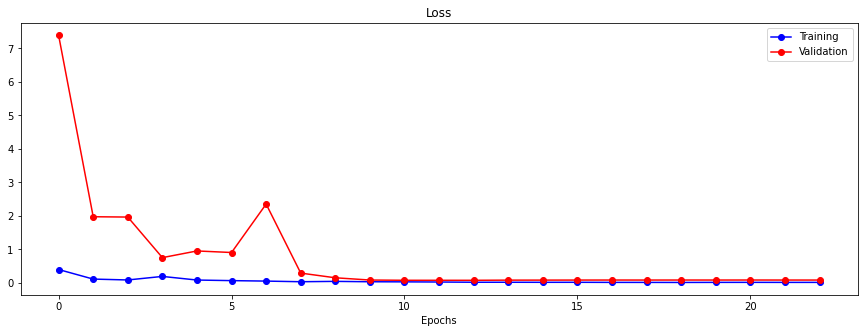

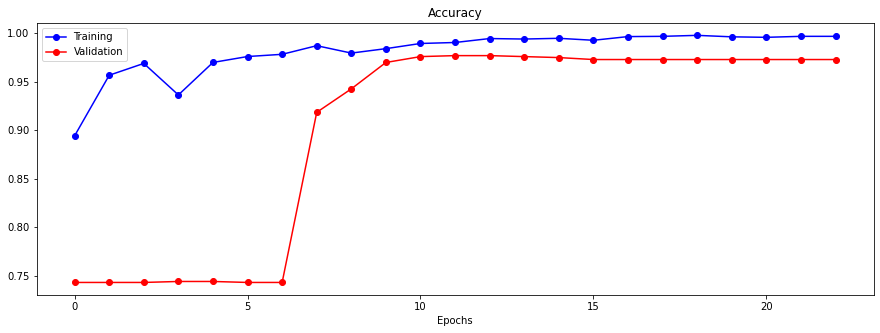

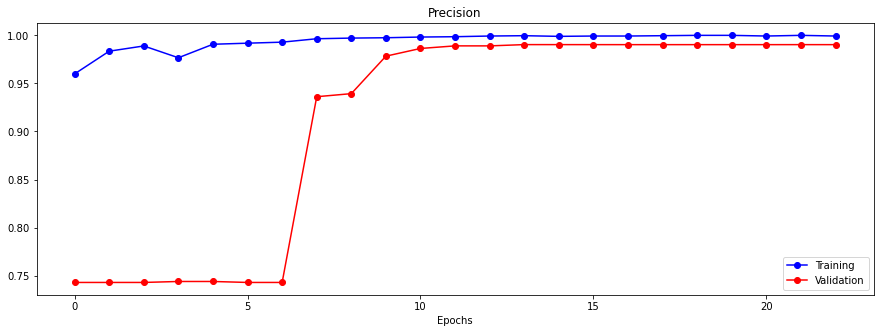

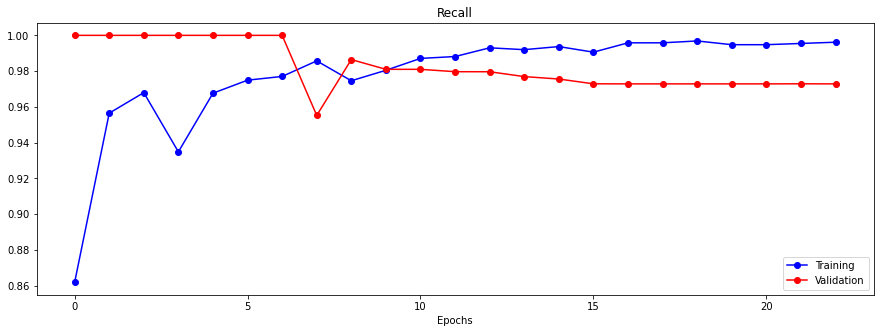

In [135]:
visualize_training_results(results_4)

In [136]:
print(TimingCallback.logs)
print(sum(TimingCallback.logs))

[53.301999740011524, 44.253028845007066, 43.37288414197974, 43.012699279002845, 43.20982967497548, 43.37468149000779, 43.157313291041646, 43.14752380200662, 43.30954349495005, 43.34677551302593, 42.761209219985176, 43.196084626019, 42.99481628002832, 43.33015383995371, 43.043080442992505, 43.162685434974264, 43.205892672995105, 43.28548826696351, 43.13980393501697, 43.19439823302673, 43.34567109198542, 42.75277510395972, 43.46154574700631, 43.07204618200194, 43.00550829601707, 43.05729542003246, 42.98619461001363, 44.14150902401889, 43.386051879031584, 42.8896359759965, 48.31133336800849, 40.84409795695683, 41.39522730599856, 41.51205377897713, 41.31380781304324, 80.95920348196523, 43.55549186700955, 42.846533384989016, 42.830149908026215, 41.29835554002784, 40.88307096197968, 40.88527389900992, 42.64146151399473, 42.29427594295703, 42.855281295021996, 42.975606636027806, 42.612640889012255, 42.60927992197685, 41.1831484559807, 41.052249197033234, 41.137544960016385, 41.42842529597692,

It's actually very interesting to see how the model appeared to be "stuck" at a local optima(?) the first 8 epochs and barely made any progress, and then turned around and increased accuracy by almost 20% from epoch 8 to epoch 9.

In [137]:
# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
resnet_train_eval_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels
    class_mode='raw',
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
resnet_val_eval_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels   
    class_mode='raw',
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False
)

preds_train_7 = cnn_7.predict(resnet_train_eval_generator, 
                                steps=(resnet_train_eval_generator.n//BATCH_SIZE+1), 
                                verbose=1,
                                workers=8)
preds_val_7 = cnn_7.predict(resnet_val_eval_generator, 
                              steps=(resnet_val_eval_generator.n//BATCH_SIZE+1),
                              verbose=1,
                              workers=8)

Found 3971 validated image filenames.
Found 993 validated image filenames.
32/32 [==============================] - 3s 67ms/step


In [138]:
cnn_7_metrics = cnn_7.evaluate(resnet_val_eval_generator)

32/32 [==============================] - 8s 247ms/step - loss: 0.0746 - accuracy: 0.9768 - recall: 0.9797 - precision: 0.9891


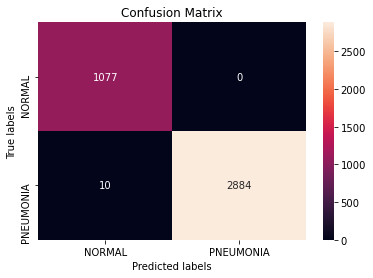

In [145]:
plot_confusionmatrix(train_df['label'], np.rint(preds_train_7))

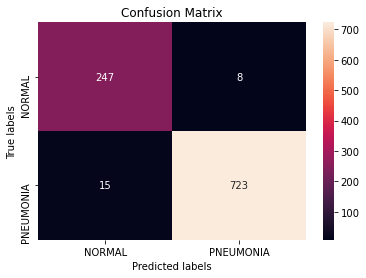

In [146]:
plot_confusionmatrix(val_df['label'], np.rint(preds_val_7))

In [147]:
# APPEND PREDICTIONS OF THE cnn_7 MODEL TO val_df FOR COMPARISON WITH
# OTHER MODELS LATER
val_df['cnn_7_pred'] = preds_val_7

In [148]:
val_df.head()

,image,label,type,cnn_3_pred,cnn_7_pred
5768,/home/agaonkar/private/chest_xray/test/PNEUMON...,1,normal,0.893336,0.993012
2985,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.999732,1.000000
2671,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.993442,1.000000
5029,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.913788,0.986590
2432,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.992479,0.999972


In [149]:
# PNEUMONIA CASES THAT HAVE BEEN INCORRECTLY PREDICTED BY cnn_7
fn7 = val_df[(val_df.label - np.rint(val_df.cnn_7_pred)) == 1]
fn7

,image,label,type,cnn_3_pred,cnn_7_pred
2725,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.842670,0.435527
4543,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.349836,0.083097
4222,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.159456,0.163694
4554,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.153600,0.041963
3773,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.653246,0.453208
3891,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.710648,0.215192
5705,/home/agaonkar/private/chest_xray/test/PNEUMON...,1,normal,0.191841,0.008118
1790,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.088389,0.271605
3493,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.200766,0.261747
1650,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.509387,0.122768


In [150]:
# PNEUMONIA CASES THAT HAVE BEEN INCORRECTLY PREDICTED BY 5 MODELS
# baseline, cnn_3, cnn_4, cnn_5, and cnn_7
fn_all = val_df[(np.rint(val_df.cnn_3_pred) == np.rint(val_df.cnn_7_pred))]
fn_all

,image,label,type,cnn_3_pred,cnn_7_pred
5768,/home/agaonkar/private/chest_xray/test/PNEUMON...,1,normal,0.893336,0.993012
2985,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.999732,1.000000
2671,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.993442,1.000000
5029,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.913788,0.986590
2432,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.992479,0.999972
...,...,...,...,...,...
4425,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.986229,0.999999
2770,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.457814,0.203049
3074,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.960649,0.989724
5819,/home/agaonkar/private/chest_xray/test/PNEUMON...,1,normal,0.979226,0.999580


In [151]:
# PNEUMONIA CASES THAT HAVE BEEN INCORRECTLY PREDICTED BY MODELS baseline & cnn_2,
# BUT CORRECTLY PREDICTED BY MODEL cnn_3
correct_by_4 = val_df[(val_df.label == 1) & \
                      (np.rint(val_df.cnn_3_pred) == 0) & \
                      (np.rint(val_df.cnn_7_pred) == 1)]
correct_by_4

,image,label,type,cnn_3_pred,cnn_7_pred
3179,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.219138,0.637004
3999,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.348171,0.968345
3239,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.468280,0.999681
3164,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.112475,0.977923
2470,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.255868,0.731541
2057,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.192652,0.831425
3270,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.431769,0.988925
3777,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.108605,0.624084
1685,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.298749,0.991473
3243,/home/agaonkar/private/chest_xray/train/PNEUMO...,1,normal,0.381234,0.627343


In [152]:
img_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=correct_by_4, x_col='image', y_col='cnn_7_pred',
    class_mode='raw',
    color_mode='grayscale',
    target_size=(180,180), batch_size=BATCH_SIZE,
    shuffle=False
)

correct_by_4_img, correct_by_4_prob = next(img_generator)

Found 11 validated image filenames.


False Negative cases by 3 previous models but corrected by cnn_4:



IndexError: index 4 is out of bounds for axis 0 with size 4

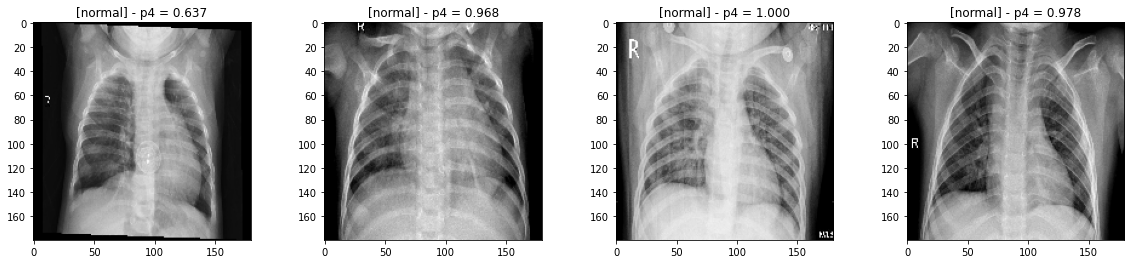

In [153]:
print('False Negative cases by 3 previous models but corrected by cnn_4:')
print()
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,4))

for i in range(len(correct_by_4)):
    ax = axes[i]
    ax.imshow(correct_by_4_img[i], cmap='gray')
    ax.set_title('[{}] - p4 = {:.3f}'.format(correct_by_4.iloc[i].type, correct_by_4_prob[i]))

plt.tight_layout()
plt.show();

In [154]:
# SAVE THE MODEL
cnn_7.save("cnn_7_gpu.h5")

### Model Evaluation
Among 4 models, `cnn_4` has the best performance all across the board and the lowest count of False Negatives. Therefore, I would proceed to do a final evaluation of its performance on the test set.

In [155]:
# CREATE GENERATOR FOR VALIDATION DATA (FROM test_df DATAFRAME)
resnet_test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=test_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels
    class_mode='raw',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False
)

Found 876 validated image filenames.


In [157]:
preds_test_4 = cnn_7.predict(resnet_test_generator,
                             steps=(resnet_test_generator.n//BATCH_SIZE+1),
                             verbose=1,
                             workers=8)

28/28 [==============================] - 2s 73ms/step


In [165]:
cnn_7_metrics= cnn_7.evaluate(resnet_test_generator)

28/28 [==============================] - 8s 265ms/step - loss: 0.0629 - accuracy: 0.9783 - recall: 0.9810 - precision: 0.9889


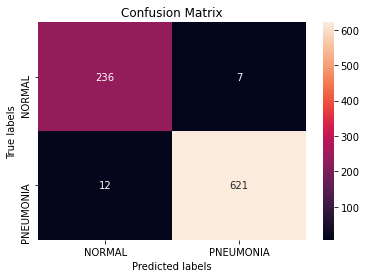

In [159]:
plot_confusionmatrix( test_df['label'], np.rint(preds_test_4))

In [166]:
perf_df.loc[len(perf_df.index)] = ['CNN_Resnet_pretrained'] + cnn_7_metrics
perf_df

,model,loss,accuracy,recall,precision
0,CNN_augmented,0.109097,0.962329,0.979463,0.968750
1,CNN_Resnet_pretrained,0.062891,0.978311,0.981043,0.988854


In [160]:
from sklearn.metrics import confusion_matrix
from math import sqrt

# Compute confusion matrix
cm = confusion_matrix(test_df['label'], np.rint(preds_test_3))
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = TP / (TP + 0.5 * (FP + FN))

# Matthews correlation coefficient (MCC)
mcc_numerator = TN * TP - FN * FP
mcc_denominator = sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
mcc_score = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

# Cohen's Kappa score
kappa_numerator = 2 * (TP * TN - FN * FP)
kappa_denominator = (TP + FP) * (FP + TN) + (TP + FN) * (FN + TN)
kappa_score = kappa_numerator / kappa_denominator if kappa_denominator != 0 else 0

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"MCC Score: {mcc_score:.4f}")
print(f"Kappa Score: {kappa_score:.4f}")


Accuracy: 0.9623
Precision: 0.9688
Recall: 0.9795
F1 Score: 0.9741
MCC Score: 0.9054
Kappa Score: 0.9052


Out of 617 actual Pneumonia X-rays, `cnn_4` was able to accurately detect 611, which gives us a very high Recall score of 99.02%. Overall, the model has an Accuracy score of 98.17% on the Test dataset.

## Conclusion

Although the final model has achieved very high performance scores across the board (Accuracy, Recall, as well as Precision), Grad-CAM has showed us that the model is still picking up some regions outside the lungs area.

Rather than purely pursuing better metric scores, it'd be best to take advantage of experts' domain knowledge, and have these Grad-CAM outputs reviewed by clinicians and radiologists who can provide input on whether or not the model has identified correct/potential regions the chest area that might be indicators of Pneumonia.


## Next Steps

In the future I would want to consider incorporating Object Detection/Localization into the models so that the output would not only be whether or not the X-ray exhibit abnormal pulmonary patterns typically observed in Pneumonia, but also the location of the identified patterns. However, this types of tasks usually requires data that have been labeled with bounding boxes or similar annotations, which could be very labor intensive and costly.

## References
1. Géron, A. (2019). *In Hands-on machine learning with Scikit-Learn &amp; TensorFlow: concepts, tools, and techniques to build intelligent systems.* O'Reilly Media, Inc.
2. https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
3. https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
4. https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
5. [Wikipedia](https://en.wikipedia.org/wiki/Pneumonia)